In [2]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder \
    .appName("Machine Downtime Analysis") \
    .getOrCreate()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: SparkSession$ does not exist in the JVM

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


In [2]:
# Load from HDFS
df_spark = spark.read.csv("hdfs://namenode:9000/data.csv", 
                          header=True, inferSchema=True)

# Show schema and few rows
df_spark.printSchema()
df_spark.show(5)

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, expr
import matplotlib.pyplot as plt

# Step 1: Start SparkSession
spark = SparkSession.builder \
    .appName("ArrivalsPerMonthPieChart") \
    .getOrCreate()

# Step 2: Load data from HDFS
df = spark.read.csv("hdfs://namenode:9000/data.csv", header=True, inferSchema=True)

month_order_expr = """
CASE arrival_date_month
    WHEN 'January' THEN 1
    WHEN 'February' THEN 2
    WHEN 'March' THEN 3
    WHEN 'April' THEN 4
    WHEN 'May' THEN 5
    WHEN 'June' THEN 6
    WHEN 'July' THEN 7
    WHEN 'August' THEN 8
    WHEN 'September' THEN 9
    WHEN 'October' THEN 10
    WHEN 'November' THEN 11
    WHEN 'December' THEN 12
END
"""

df_with_month_num = df.withColumn("month_num", expr(month_order_expr))
df_with_month_num.select("arrival_date_month", "month_num").show()
grouped_df = df_with_month_num.groupBy("arrival_date_month", "month_num")
#  Apply aggregation separately
aggregated_df = grouped_df.agg(count("*").alias("arrival_count"))
#Intermediate output: after aggregation
aggregated_df.show()
arrivals_per_month = aggregated_df.orderBy("month_num")

arrivals_per_month.show()

+------------------+---------+
|arrival_date_month|month_num|
+------------------+---------+
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
|              July|        7|
+------------------+---------+
only showing top 20 rows

+------------------+---------+-------------+
|arrival_date_month|month_num|arrival_count|
+------------------+---------+-------------+
|              June|        6|        10939|
|           January|        1|         5929|
|    

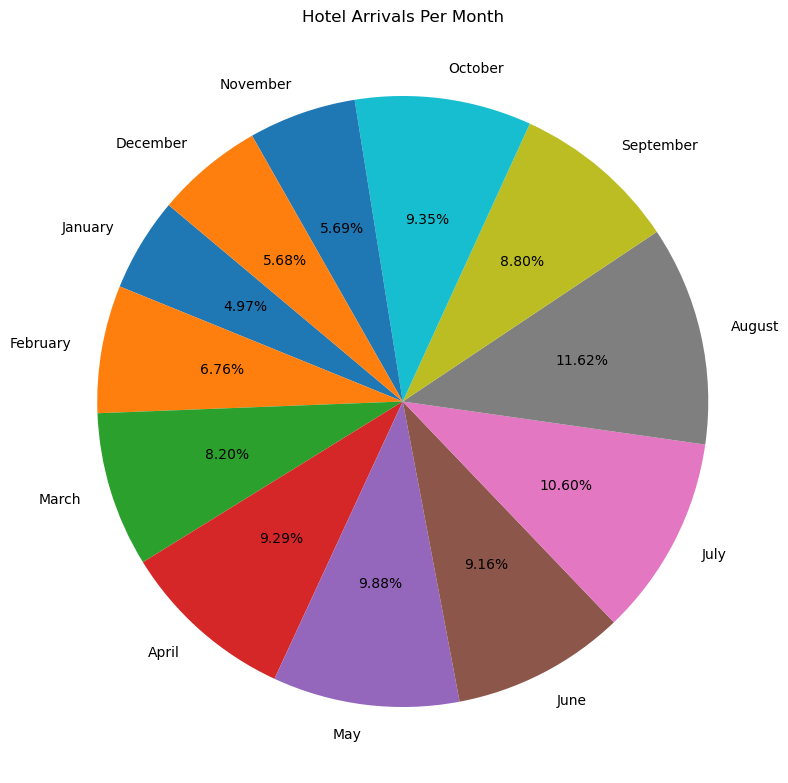

In [5]:


pdf = arrivals_per_month.toPandas()


plt.figure(figsize=(8, 8))
plt.pie(
    pdf["arrival_count"],
    labels=pdf["arrival_date_month"],
    autopct="%0.2f%%",
    startangle=140
)
plt.title("Hotel Arrivals Per Month")
plt.axis("equal") 
plt.tight_layout()
plt.show()


In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, month, date_format
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder \
    .appName("HotelBookingMapReduceVisualization") \
    .getOrCreate()


df = spark.read.csv("hdfs://namenode:9000/data.csv", header=True, inferSchema=True)


df_filtered = df.select("hotel", "is_canceled", "arrival_date_year", "arrival_date_month")

from pyspark.sql.functions import expr

month_order_expr = """
CASE arrival_date_month
    WHEN 'January' THEN 1
    WHEN 'February' THEN 2
    WHEN 'March' THEN 3
    WHEN 'April' THEN 4
    WHEN 'May' THEN 5
    WHEN 'June' THEN 6
    WHEN 'July' THEN 7
    WHEN 'August' THEN 8
    WHEN 'September' THEN 9
    WHEN 'October' THEN 10
    WHEN 'November' THEN 11
    WHEN 'December' THEN 12
END
"""

df_with_month_num = df_filtered.withColumn("month_num", expr(month_order_expr))


print("✅ STEP 1: Data with `month_num`")
df_with_month_num.select("arrival_date_month", "month_num", "hotel", "is_canceled").show(10)

# GroupBy only (no aggregation yet)
grouped_data = df_with_month_num.groupBy("arrival_date_month", "month_num", "hotel")


# Apply Aggregation to Count Cancellations
agg_df = grouped_data.agg(
    count(when(col("is_canceled") == 1, True)).alias("cancellations")
)
agg_df.show(10)



✅ STEP 1: Data with `month_num`
+------------------+---------+------------+-----------+
|arrival_date_month|month_num|       hotel|is_canceled|
+------------------+---------+------------+-----------+
|              July|        7|Resort Hotel|          0|
|              July|        7|Resort Hotel|          0|
|              July|        7|Resort Hotel|          0|
|              July|        7|Resort Hotel|          0|
|              July|        7|Resort Hotel|          0|
|              July|        7|Resort Hotel|          0|
|              July|        7|Resort Hotel|          0|
|              July|        7|Resort Hotel|          0|
|              July|        7|Resort Hotel|          1|
|              July|        7|Resort Hotel|          1|
+------------------+---------+------------+-----------+
only showing top 10 rows

+------------------+---------+------------+-------------+
|arrival_date_month|month_num|       hotel|cancellations|
+------------------+---------+------------

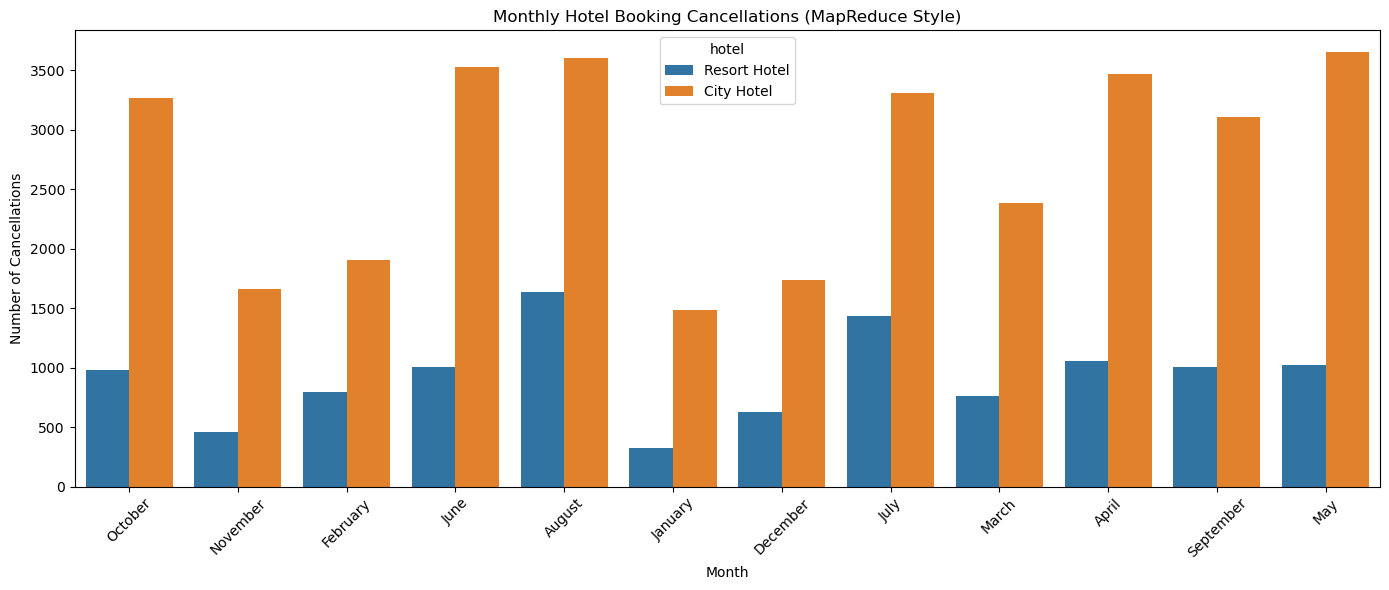

In [9]:
pandas_df = agg_df.toPandas()


plt.figure(figsize=(14, 6))
sns.barplot(data=pandas_df, x="arrival_date_month", y="cancellations", hue="hotel")
plt.title("Monthly Hotel Booking Cancellations (MapReduce Style)")
plt.xlabel("Month")
plt.ylabel("Number of Cancellations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_312/2998507009.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="market_segment", y="count", data=pdf, palette='rocket')


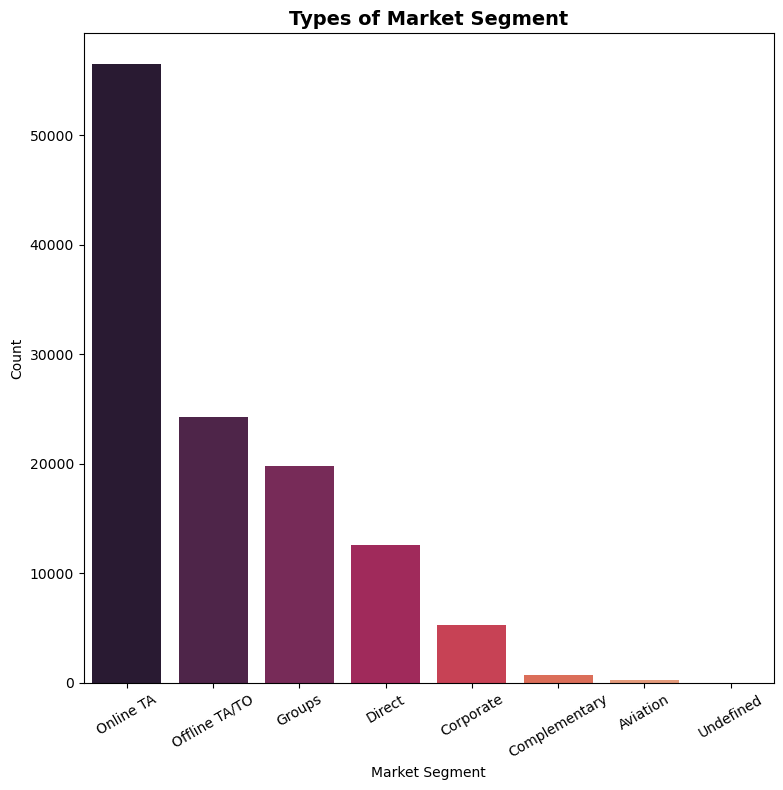

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns


spark = SparkSession.builder \
    .appName("MarketSegmentPlot") \
    .getOrCreate()


df = spark.read.csv("hdfs://namenode:9000/data.csv", header=True, inferSchema=True)


df_segment = df.select("market_segment")

#Group by market segment (MapReduce-style count)
segment_counts = df_segment.groupBy("market_segment").count().orderBy("count", ascending=False)

pdf = segment_counts.toPandas()


plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
sns.barplot(x="market_segment", y="count", data=pdf, palette='rocket')
plt.title('Types of Market Segment', fontweight="bold", fontsize=14)
plt.xlabel("Market Segment")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


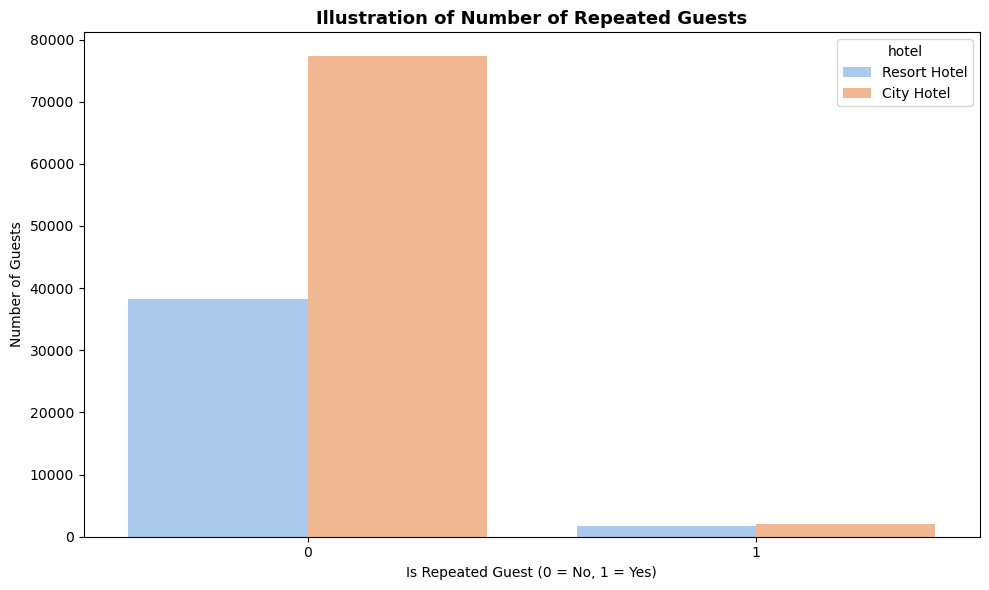

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder \
    .appName("RepeatedGuestsPlot") \
    .getOrCreate()


df = spark.read.csv("hdfs://namenode:9000/data.csv", header=True, inferSchema=True)


df_guests = df.select("is_repeated_guest", "hotel")

# Group by repeated_guest + hotel (MapReduce-style)
guest_counts = df_guests.groupBy("is_repeated_guest", "hotel").count()


pdf = guest_counts.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=pdf, x="is_repeated_guest", y="count", hue="hotel", palette="pastel")
plt.title("Illustration of Number of Repeated Guests", fontweight="bold", fontsize=13)
plt.xlabel("Is Repeated Guest (0 = No, 1 = Yes)")
plt.ylabel("Number of Guests")
plt.tight_layout()
plt.show()


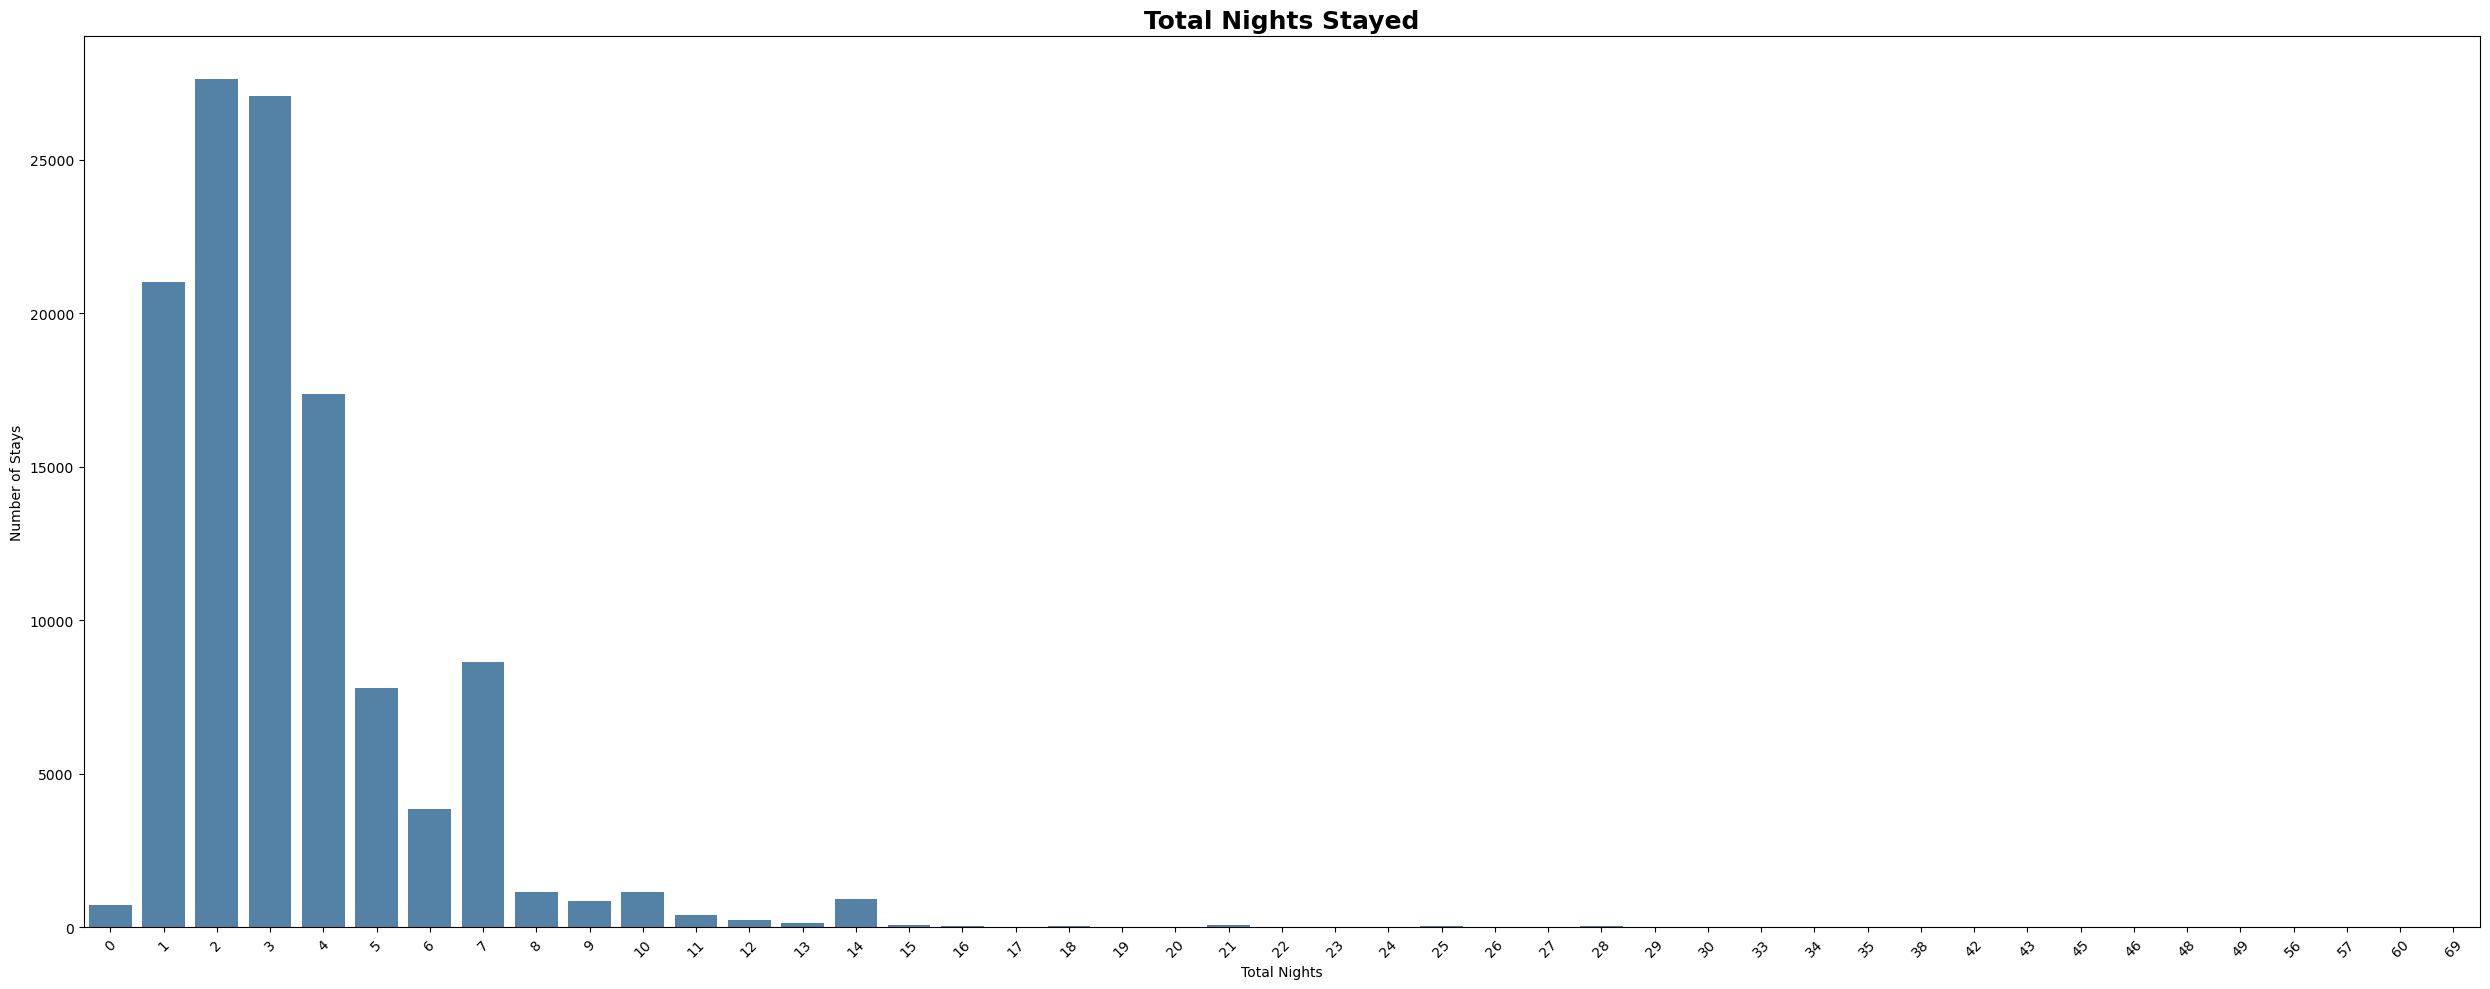

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder \
    .appName("TotalNightsStayedPlot") \
    .getOrCreate()


df = spark.read.csv("hdfs://namenode:9000/data.csv", header=True, inferSchema=True)

df = df.withColumn("total_nights", col("stays_in_weekend_nights") + col("stays_in_week_nights"))

# Group by total_nights to get counts (MapReduce-style)
nights_df = df.groupBy("total_nights").count().orderBy("total_nights")


pdf = nights_df.toPandas()


plt.figure(figsize=(25, 10))
sns.barplot(data=pdf, x="total_nights", y="count", color='steelblue')
plt.title("Total Nights Stayed", fontsize=18, fontweight="bold")
plt.xlabel("Total Nights")
plt.ylabel("Number of Stays")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


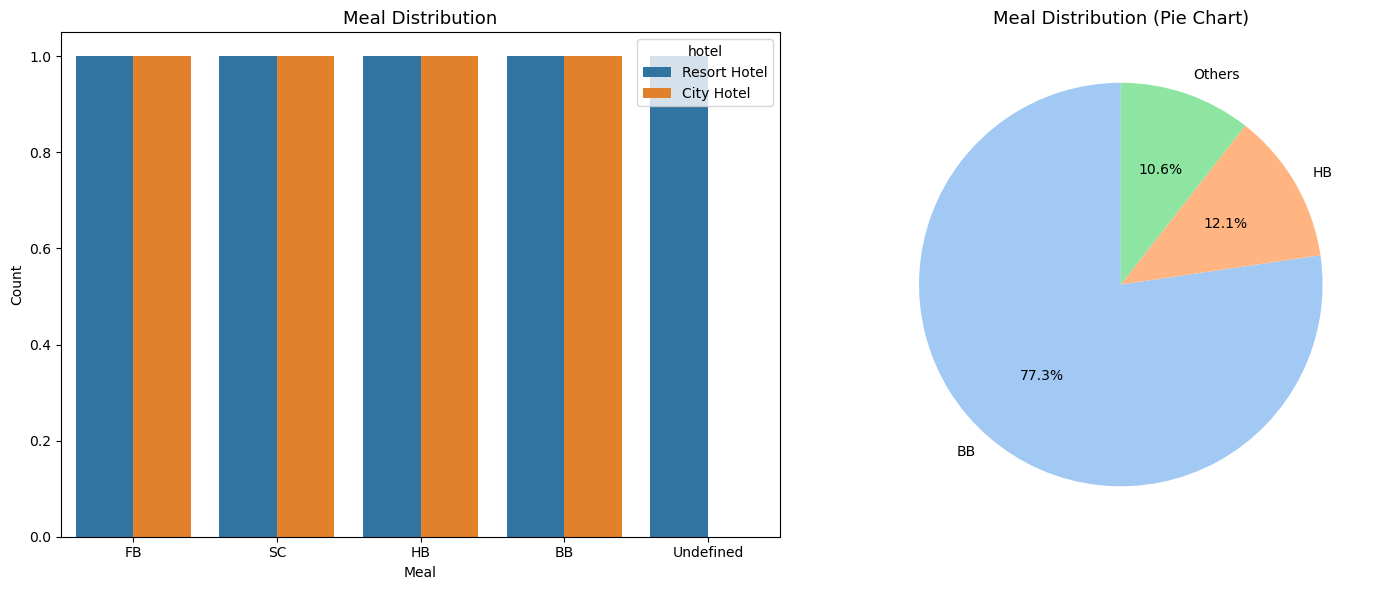

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder \
    .appName("MealDistributionVisualization") \
    .getOrCreate()

df = spark.read.csv("hdfs://namenode:9000/data.csv", header=True, inferSchema=True)

meal_by_hotel = df.groupBy("meal", "hotel").count()

# Count total meals (for pie chart)
meal_counts = df.groupBy("meal").count().orderBy("count", ascending=False)
meal_counts_pdf = meal_counts.toPandas()

top_meals = meal_counts_pdf[:-3].copy()
others_sum = meal_counts_pdf[-3:]["count"].sum()
top_meals.loc[len(top_meals.index)] = ["Others", others_sum]  # Add 'Others' row

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

countplot_data = meal_by_hotel.toPandas()
sns.countplot(data=countplot_data, x="meal", hue="hotel", ax=axes[0])
axes[0].set_title("Meal Distribution", fontsize=13)
axes[0].set_xlabel("Meal")
axes[0].set_ylabel("Count")


axes[1].pie(
    top_meals["count"],
    labels=top_meals["meal"],
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('pastel')
)
axes[1].set_title("Meal Distribution (Pie Chart)", fontsize=13)

plt.tight_layout()
plt.show()


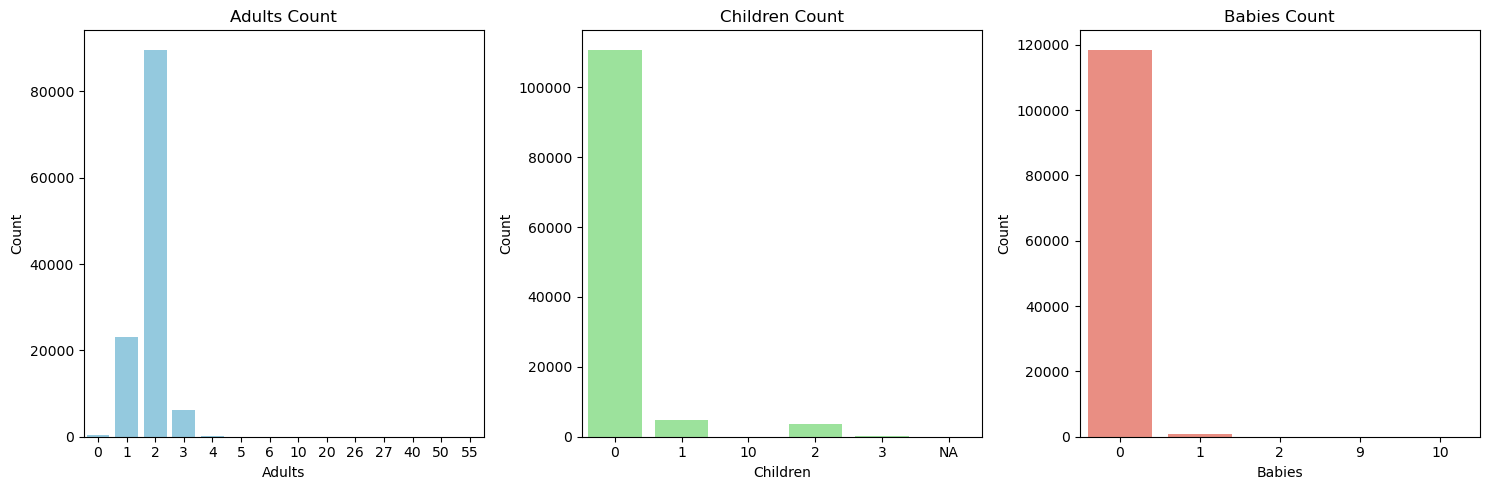

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder \
    .appName("GuestCompositionPlots") \
    .getOrCreate()


df = spark.read.csv("hdfs://namenode:9000/data.csv", header=True, inferSchema=True)

#Group and count each demographic column
adults_count = df.groupBy("adults").count().orderBy("adults").toPandas()
children_count = df.groupBy("children").count().orderBy("children").toPandas()
babies_count = df.groupBy("babies").count().orderBy("babies").toPandas()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(x='adults', y='count', data=adults_count, ax=axes[0], color='skyblue')
axes[0].set_title('Adults Count')
axes[0].set_xlabel('Adults')
axes[0].set_ylabel('Count')

sns.barplot(x='children', y='count', data=children_count, ax=axes[1], color='lightgreen')
axes[1].set_title('Children Count')
axes[1].set_xlabel('Children')
axes[1].set_ylabel('Count')

sns.barplot(x='babies', y='count', data=babies_count, ax=axes[2], color='salmon')
axes[2].set_title('Babies Count')
axes[2].set_xlabel('Babies')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()


/tmp/ipykernel_312/2634893492.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf, x="customer_type", y="count", palette="Set2")


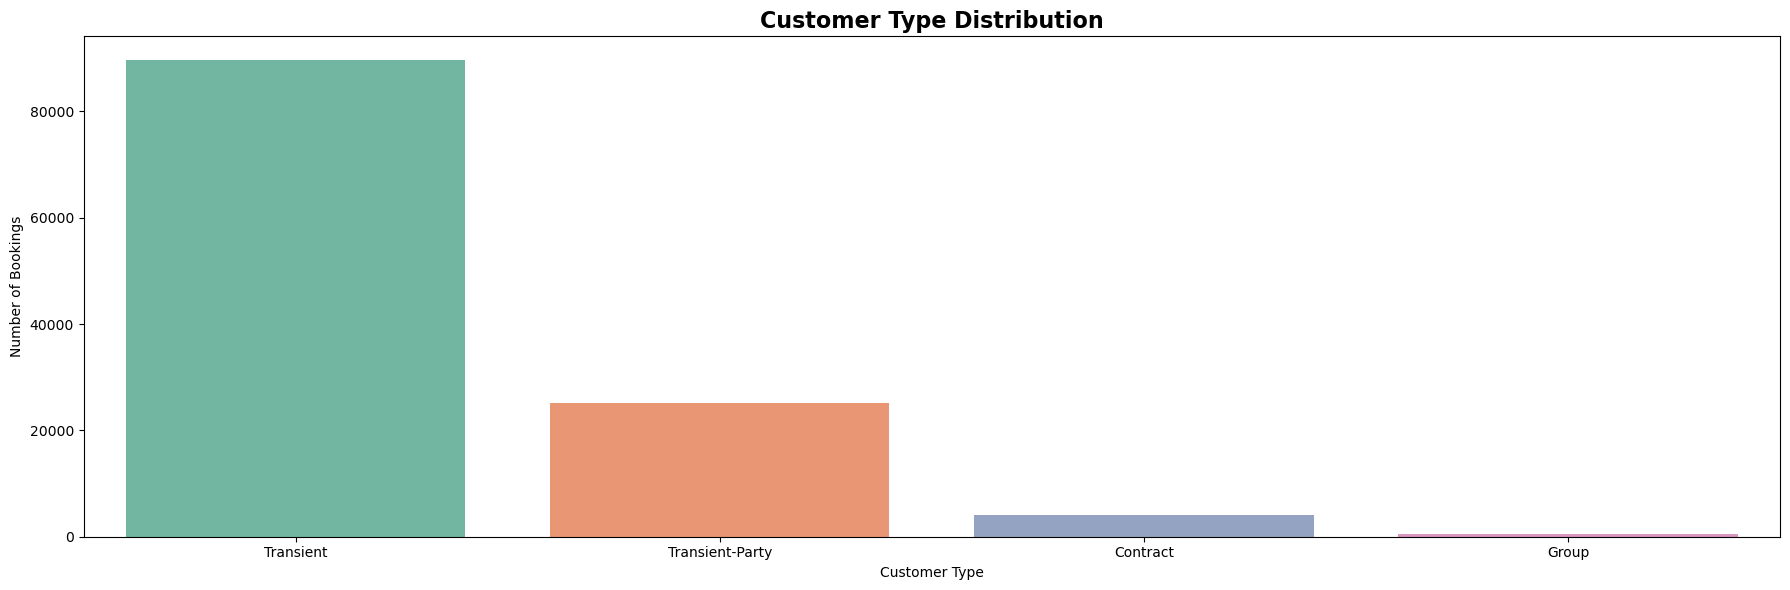

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
import seaborn as sns


spark = SparkSession.builder \
    .appName("CustomerTypeDistribution") \
    .getOrCreate()


df = spark.read.csv("hdfs://namenode:9000/data.csv", header=True, inferSchema=True)

# MapReduce-style aggregation (count of customer types)
customer_counts = df.groupBy("customer_type").count().orderBy("count", ascending=False)

pdf = customer_counts.toPandas()


plt.figure(figsize=(18, 6))
sns.barplot(data=pdf, x="customer_type", y="count", palette="Set2")
plt.title("Customer Type Distribution", fontsize=16, fontweight="bold")
plt.xlabel("Customer Type")
plt.ylabel("Number of Bookings")
plt.tight_layout()
plt.show()


In [14]:
!pip install plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 1.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.2/365.2 kB 807.5 kB/s eta 0:00:000:0100:01


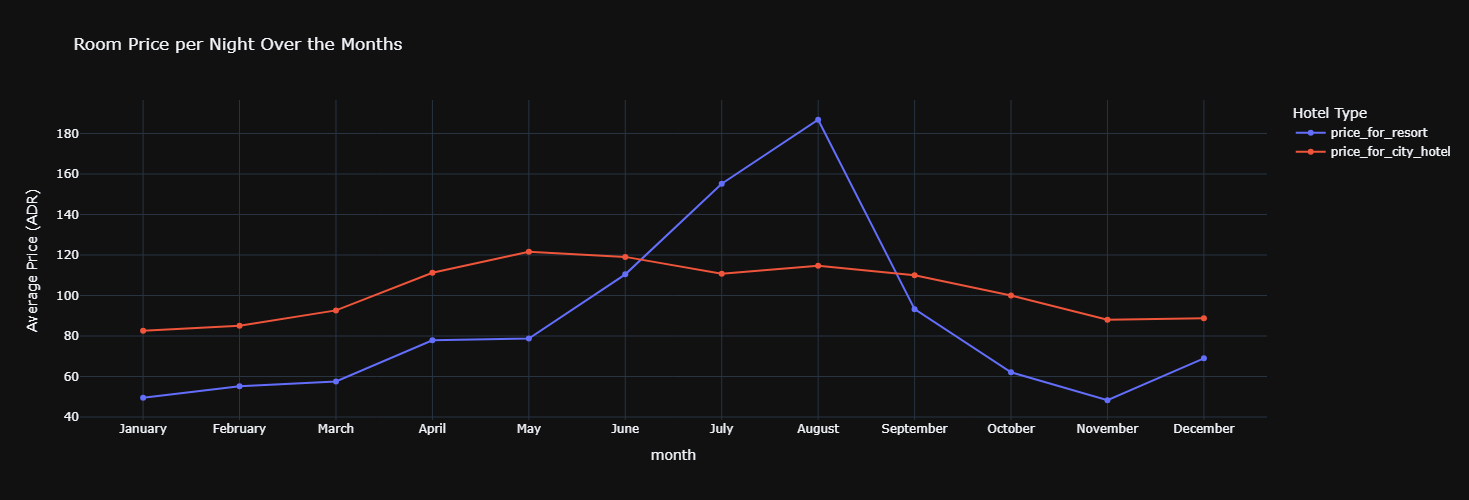

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, expr
import pandas as pd              # ✅ Add this
import plotly.express as px


spark = SparkSession.builder \
    .appName("RoomPriceOverMonths") \
    .getOrCreate()

df = spark.read.csv("hdfs://namenode:9000/data.csv", header=True, inferSchema=True)

month_expr = """
CASE arrival_date_month
    WHEN 'January' THEN 1
    WHEN 'February' THEN 2
    WHEN 'March' THEN 3
    WHEN 'April' THEN 4
    WHEN 'May' THEN 5
    WHEN 'June' THEN 6
    WHEN 'July' THEN 7
    WHEN 'August' THEN 8
    WHEN 'September' THEN 9
    WHEN 'October' THEN 10
    WHEN 'November' THEN 11
    WHEN 'December' THEN 12
END
"""

df = df.withColumn("month_num", expr(month_expr))

# Compute average price per hotel per month
avg_prices = df.groupBy("arrival_date_month", "month_num", "hotel") \
               .agg(avg("adr").alias("average_price")) \
               .orderBy("month_num")


pdf = avg_prices.toPandas()

final_prices = pdf.pivot(index="arrival_date_month", columns="hotel", values="average_price").reset_index()

month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
final_prices["arrival_date_month"] = pd.Categorical(final_prices["arrival_date_month"], categories=month_order, ordered=True)
final_prices = final_prices.sort_values("arrival_date_month")
final_prices.rename(columns={
    "arrival_date_month": "month",
    "Resort Hotel": "price_for_resort",
    "City Hotel": "price_for_city_hotel"
}, inplace=True)

fig = px.line(final_prices,
              x='month',
              y=['price_for_resort', 'price_for_city_hotel'],
              title='Room Price per Night Over the Months',
              template='plotly_dark',
              markers=True,
              labels={'value': 'Average Price (ADR)', 'variable': 'Hotel Type'})
fig.update_layout(width=1000, height=500)
fig.show()


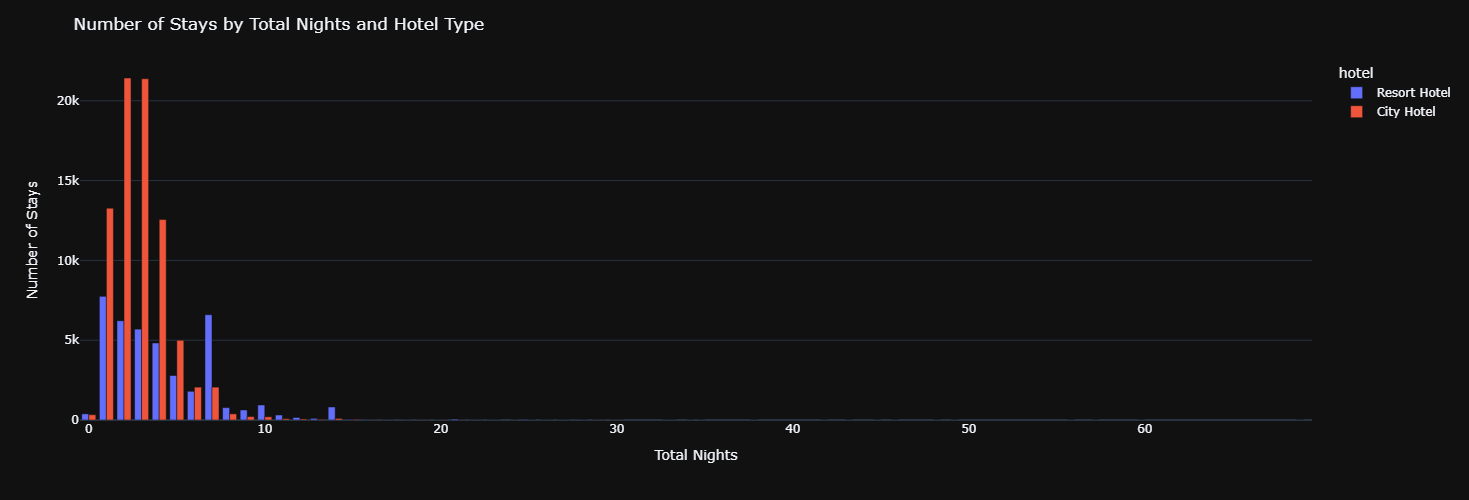

In [3]:
from pyspark.sql.functions import col 

df = df.withColumn("total_nights", col("stays_in_weekend_nights") + col("stays_in_week_nights"))

stay = df.groupBy("total_nights", "hotel").count().withColumnRenamed("count", "Number of stays")

stay_pdf = stay.toPandas()

import plotly.express as px  # Make sure this is also imported
fig = px.bar(
    data_frame=stay_pdf,
    x='total_nights',
    y='Number of stays',
    color='hotel',
    barmode='group',
    template='plotly_dark',
    labels={'total_nights': 'Total Nights', 'Number of stays': 'Number of Stays'}
)

fig.update_layout(title='Number of Stays by Total Nights and Hotel Type', width=1000, height=500)
fig.show()


In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import plotly.express as px

spark = SparkSession.builder \
    .appName("BoxPlotADRvsRoomType") \
    .getOrCreate()


df = spark.read.csv("hdfs://namenode:9000/data.csv", header=True, inferSchema=True)


# ✅ Step 1: Filter non-canceled bookings
df_filtered = df.filter(col("is_canceled") == 0)

# ✅ Step 2: Remove outliers where ADR >= 1000
df_filtered = df_filtered.filter(col("adr") < 1000)

# ✅ Step 3: Group by reserved room type and hotel and collect ADRs
# This is not exactly a "box plot" aggregation, but it's the preparatory work
grouped_stats = df_filtered.groupBy("reserved_room_type", "hotel") \
    .agg(
        expr("percentile(adr, array(0.25))")[0].alias("Q1"),
        expr("percentile(adr, array(0.5))")[0].alias("Median"),
        expr("percentile(adr, array(0.75))")[0].alias("Q3"),
        expr("min(adr)").alias("Min"),
        expr("max(adr)").alias("Max"),
        expr("avg(adr)").alias("Average"),
        expr("count(*)").alias("Count")
    )

# ✅ Show the grouped box-style summary table
grouped_stats.orderBy("reserved_room_type", "hotel").show(truncate=False)



+------------------+------------+------------------+------------------+------------------+-----+------+------------------+-----+
|reserved_room_type|hotel       |Q1                |Median            |Q3                |Min  |Max   |Average           |Count|
+------------------+------------+------------------+------------------+------------------+-----+------+------------------+-----+
|A                 |City Hotel  |76.5              |94.5              |115.0             |0.0  |510.0 |96.54841287803855 |35347|
|A                 |Resort Hotel|42.3              |58.98             |90.0              |-6.38|508.0 |73.80352412293593 |17017|
|B                 |City Hotel  |75.875            |86.5              |101.08            |0.0  |263.55|87.35575635876835 |747  |
|B                 |Resort Hotel|90.0              |110.0             |122.0             |70.0 |134.0 |104.66666666666667|3    |
|C                 |City Hotel  |0.0               |74.0              |110.0             |0.0  |1

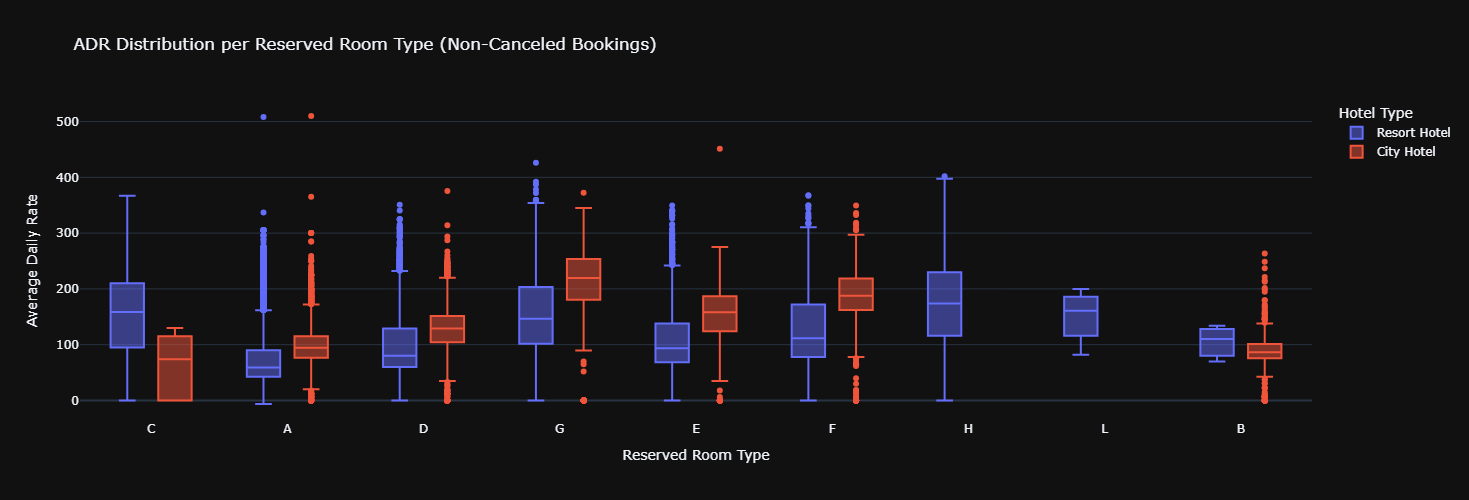

In [16]:

df_filtered = df.filter(col("is_canceled") == 0)

box_data = df_filtered.select("reserved_room_type", "adr", "hotel")

box_pdf = box_data.toPandas()

box_pdf = box_pdf[box_pdf["adr"] < 1000]

fig = px.box(
    data_frame=box_pdf,
    x='reserved_room_type',
    y='adr',
    color='hotel',
    template='plotly_dark',
    points="outliers",
    labels={
        "adr": "Average Daily Rate",
        "reserved_room_type": "Reserved Room Type",
        "hotel": "Hotel Type"
    },
    title="ADR Distribution per Reserved Room Type (Non-Canceled Bookings)"
)

fig.update_layout(width=1000, height=500)
fig.show()
